In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.framework import ops
import os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from cnn_utils import *

%matplotlib inline

In [2]:
save_to_file_dir = './qiao_logs/saved_logs'

In [3]:
h5f = h5py.File('saved_gray.h5', 'r')

X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_valid = h5f['X_valid'][:]
y_valid = h5f['y_valid'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
# X_train = np.concatenate((X_train, X_valid), axis=0)
# y_train = np.concatenate((y_train, y_valid), axis=0)

h5f.close()

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

((58605, 32, 32, 1), (58605, 10))
((14652, 32, 32, 1), (14652, 10))
((26032, 32, 32, 1), (26032, 10))


In [4]:
tf.test.is_gpu_available()

True

In [5]:
def show_img(img):
    fig,ax = plt.subplots()
    if img.shape == (32,32,3):
        ax.imshow(img)
    else:
        ax.imshow(img[:,:,0])

In [6]:
def set_up_log_dir(): 
    if tf.gfile.Exists(save_to_file_dir):
        tf.gfile.DeleteRecursively(save_to_file_dir)
    tf.gfile.MakeDirs(save_to_file_dir)

In [7]:
def get_batch(X,y,batch_size=512):
    for i in np.arange(0,y.shape[0], batch_size):
        end = min(X.shape[0], i+batch_size)
        yield (X[i:end], y[i:end])
        

In [8]:
def create_placeholders():
    tf.logging.set_verbosity(tf.logging.INFO)

    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='Input')
    y = tf.placeholder(tf.float32, shape=[None, 10], name='Label')
    dropout = tf.placeholder(tf.float32, name='dropout')

    os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
    return x,y,dropout

In [9]:
XX,YY,dropout = create_placeholders()
print('XX = ' + str(XX))
print('YY = ' + str(YY))    

XX = Tensor("Input:0", shape=(?, 32, 32, 1), dtype=float32)
YY = Tensor("Label:0", shape=(?, 10), dtype=float32)


In [10]:
def initial():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [6, 6, 1, 8], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    W2 = tf.get_variable("W2", [6, 6, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    W3 = tf.get_variable("W3", [6, 6, 16, 32], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    W4 = tf.get_variable("W4", [4, 4, 32, 16], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    W5 = tf.get_variable("W5", [4, 4, 16, 8], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    W6 = tf.get_variable("W6", [4, 4, 8, 4], initializer=tf.contrib.layers.xavier_initializer(seed=4))
    parameters = {"W1" : W1,
                  "W2" : W2,
                  "W3" : W3,  
                  "W4" : W4,
                  "W5" : W5,
                  "W6" : W6}
    return parameters

In [11]:
def cnn(XX,dropout,  parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    W5 = parameters["W5"]
    W6 = parameters["W6"]
    print(XX.shape)
    Z1 = tf.nn.conv2d(XX, W1, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ", Z1.shape)
    A1 = tf.nn.relu(Z1)
    dropout_1 = tf.layers.dropout(inputs = A1, rate = dropout)
    Z2 = tf.nn.conv2d(dropout_1, W2, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ",Z2.shape)
    A2 = tf.nn.relu(Z2)
    dropout_2 = tf.layers.dropout(inputs = A2, rate = dropout)
    
    Z3 = tf.nn.conv2d(dropout_2, W3, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ", Z3.shape)
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = [1, 4, 4, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print("max_pool : ",P3.shape)
    Z4 = tf.nn.conv2d(P3, W4, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ", Z4.shape)
    A4 = tf.nn.relu(Z4)
    dropout_3 = tf.layers.dropout(inputs = A4, rate = dropout)
    P4 = tf.nn.max_pool(dropout_3, ksize = [1, 4, 4, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print("max_pool : ",P4.shape)
    
    Z5 = tf.nn.conv2d(P4, W5, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ", Z5.shape)
    A5 = tf.nn.relu(Z5)
    dropout_4 = tf.layers.dropout(inputs = A5, rate = dropout)
    P5 = tf.nn.max_pool(dropout_4, ksize = [1, 4, 4, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print("max_pool : ",P5.shape)
    
    Z6 = tf.nn.conv2d(P5, W6, strides = [1, 1, 1, 1], padding = "SAME")
    print("conv : ", Z6.shape)
    A6 = tf.nn.relu(Z6)
    P6 = tf.nn.max_pool(A6, ksize = [1, 4, 4, 1], strides = [1, 2, 2, 1], padding = "SAME")
    print("max_pool : ",P6.shape)
    
    P6 = tf.contrib.layers.flatten(P6)
    print(P6.shape)
    dropout_5 = tf.layers.dropout(inputs = P6, rate = dropout)
    ZZ = tf.contrib.layers.fully_connected(dropout_5, 10, activation_fn=None)
    print(ZZ.shape)
    return ZZ

In [12]:
def calc_cost(ZZ,YY):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=ZZ, labels=YY))
    return cost

In [13]:
learning_rate = 0.0005
num_epoches = 50
minibatch_size = 32


(?, 32, 32, 1)
('conv : ', TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(8)]))
('conv : ', TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(16)]))
('conv : ', TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(32)]))
('max_pool : ', TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(32)]))
('conv : ', TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(16)]))
('max_pool : ', TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(16)]))
('conv : ', TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(8)]))
('max_pool : ', TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(8)]))
('conv : ', TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(4)]))
('max_pool : ', TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(4)]))
(?, 16)
(?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gra

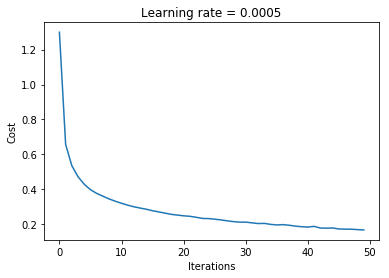

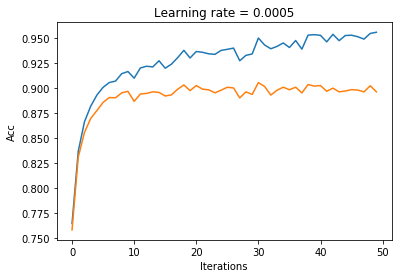

Tensor("Mean_51:0", shape=(), dtype=float32)
Training acc:0.9559807777404785
Validation acc:0.8962599
Test acc:0.8998156
INFO:tensorflow:Restoring parameters from ./qiao_logs/cnn
Test acc:0.8998156


In [14]:
tf.set_random_seed(1)
seed = 5
train_loss = []
train_cost = []
valid_cost = []
train_acc = []
valid_acc = []
step = 0
XX,YY,dropout = create_placeholders()
parameters = initial()

ZZ = cnn(XX, dropout, parameters)
cost_temp = calc_cost(ZZ, YY)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_temp)

init = tf.global_variables_initializer()

predict_op = tf.argmax(ZZ, 1)
correct_prediction = tf.equal(predict_op, tf.argmax(YY,1))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(num_epoches):
        print ('Training .........\n')
        print('Epoch', epoch+1, ': ........ \n')
        
        m = X_train.shape[0]
        num_minibatches = int(m / minibatch_size)
        seed = seed + 1
        minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
        
        print ('Get mini batches .........\n')
        
        minibatch_cost = 0.
        
        for (epoch_x, epoch_y) in minibatches:
            _, c = sess.run([optimizer, cost_temp], feed_dict={XX: epoch_x, YY: epoch_y, dropout: 0.5})
            minibatch_cost += c / num_minibatches
        train_cost.append(minibatch_cost)
        print ("train loss:.....", minibatch_cost)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        train_accuracy1 = accuracy.eval({XX:X_train[:30000], YY:y_train[:30000], dropout:0.0})
        train_accuracy2 = accuracy.eval({XX:X_train[30000:], YY:y_train[30000:], dropout:0.0})
        train_a = (train_accuracy1 + train_accuracy2) / 2.
        valid_a = accuracy.eval({XX:X_valid, YY:y_valid, dropout:0.0})
        train_acc.append(train_a)
        valid_acc.append(valid_a)
                
        step = step + 1
        
    plt.plot(np.squeeze(train_cost))
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()

    plt.plot(np.squeeze(train_acc))
    plt.plot(np.squeeze(valid_acc))
    plt.ylabel('Acc')
    plt.xlabel('Iterations')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()


    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print(accuracy)
    train_accuracy1 = accuracy.eval({XX:X_train[:30000], YY:y_train[:30000], dropout:0.0})
    train_accuracy2 = accuracy.eval({XX:X_train[30000:], YY:y_train[30000:], dropout:0.0})
    train_accuracy = (train_accuracy1 + train_accuracy2) / 2.
    print('Training acc:' + str(train_accuracy))
    valid_accuracy = accuracy.eval({XX:X_valid, YY:y_valid, dropout:0.0})
    print('Validation acc:' + str(valid_accuracy))
    test_accuracy = accuracy.eval({XX:X_test, YY:y_test, dropout:0.0})
    print('Test acc:' + str(test_accuracy))
    
    
    saver = tf.train.Saver()
    save_dir = './qiao_logs/'
    save_path = os.path.join(save_dir, 'cnn')
    saver.save(sess=sess, save_path=save_path)
               
    saver.restore(sess, save_path)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    test_accuracy = accuracy.eval({XX:X_test, YY:y_test, dropout:0.0})
    print('Test acc:' + str(test_accuracy))

              